In [1]:
!rm -r /content/NLP-DL-Group2/
!cd /content && git clone -b fnn https://github.com/AnshulH/NLP-DL-Group2

rm: cannot remove '/content/NLP-DL-Group2/': No such file or directory
Cloning into 'NLP-DL-Group2'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 111 (delta 29), reused 18 (delta 5), pack-reused 46
Receiving objects: 100% (111/111), 30.88 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import re
from nltk.util import ngrams

In [10]:
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                # Added lower-casing
                line = line.lower()
                
                # Strips out all charcters other than alphanumeric
                line = re.sub('[\W_]+', ' ', line, flags=re.UNICODE)
                
                # Strips out numbers
                line = re.sub('\d+', '', line)
                
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

In [11]:
params = {
        'd_model': 100,
        'd_hidden': 100,
        'n_layers': 2,
        'batch_size': 20,
        'seq_len': 30,
        'printevery': 5000,
        'window': 3,
        'epochs': 20,
        'lr': 0.0001,
        'dropout': 0.35,
        'clip': 2.0,
        'model': 'FFNN',
        'savename': 'lstm',
        'loadname': None,
        'trainname': '/content/NLP-DL-Group2/hw#1/mix.train.txt',
        'validname': '/content/NLP-DL-Group2/hw#1/mix.valid.txt',
        'testname': '/content/NLP-DL-Group2/hw#1/mix.test.txt'
    }
torch.manual_seed(0)

[vocab,words,train] = read_encode(params['trainname'],[],{},[],5)
print('vocab: %d, words: %d, train: %d' % (len(vocab), len(words), len(train)))

[vocab,words,train] = read_encode('/content/NLP-DL-Group2/hw#1/fake.train.txt',vocab,words,train,5)
print('vocab: %d, words: %d, train: %d' % (len(vocab), len(words), len(train)))

[vocab,words,test] = read_encode(params['testname'], vocab,words,[],-1)
print('vocab: %d test: %d' % (len(vocab),len(test)))
params['vocab_size'] = len(vocab)

vocab: 22999, words: 22999, train: 3366260
vocab: 26605, words: 26604, train: 6642203
vocab: 26605 test: 441210


In [12]:
# Returns bios in [(bio without puncutation, label), ...]
# 0: FAKE
# 1: REAL
def read_bios(file_name, labels=False):
    with open(file_name,'rt', encoding='utf8') as f:
        all_bios = f.readlines()
        
    split_bios = []
    curr_bio = ""
    curr_index = 0
    while curr_index < len(all_bios):
        curr_line = all_bios[curr_index].lower()
        # Strips out all charcters other than alphanumeric
        curr_line = re.sub('[\W_]+', ' ', curr_line, flags=re.UNICODE)
        
        # Strips out numbers
        curr_line = re.sub('\d+', '', curr_line)
        
        curr_line = curr_line.strip()
        
        if curr_line == "start bio":
            # Skips their name
            curr_index += 1
        
        elif curr_line == "end bio":
          if labels:
            curr_index += 2
            if "FAKE" in all_bios[curr_index]:
                label = 0
            else:
                label = 1

            split_bios.append((curr_bio, label))
            curr_bio = ""
          
          else:
            split_bios.append((curr_bio, 0))
            curr_bio = ""
        
        else:
            # Check to ensure not empty space
            if curr_line:
                if curr_bio == "":
                    curr_bio = curr_line
                else:
                    curr_bio += " " +  curr_line
        
        curr_index += 1
        
    
    return split_bios

In [13]:
# Create windows
# split_bios: [(bio without puncutation, label), ...]
# Returns sliding windows (multiple per biography):
# [
#  [
#   (['Hildebrand', 'Bothe', 'October'], 'September'),
#   (['Bothe', 'October', 'September'], 'was'),
#  ],
#  [
#   ([Hermann', 'Robert', 'Kaiser'], 'September'),
#   ...
#  ]
# ]

# Reference: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
def create_windows(split_bios, window_size):
    sliding_windows = []
    for bio, label in split_bios:
        bio_without_nums = ''.join([i for i in bio if not i.isdigit()])
        tokens = [token for token in bio_without_nums.split(" ") if token != ""]
        
        ngrams = []
        for i in range(len(tokens) - window_size):
            ngrams.append((
                [tokens[i + j] for j in range(window_size)],
                tokens[i + window_size]
            ))
        
        sliding_windows.append((ngrams, label))
    
    return sliding_windows

In [14]:
def create_context_and_next_words(windows):
  all_context = []
  all_next_words = []
  skipped_labels = 0

  for (each_bio, bio_label) in windows:
    # Considering only fake windows for training the model
    if bio_label == 0:
      for context, label in each_bio:
          found_in_words = [word in words for word in context]
          found_in_words.extend([label in words])
          if all(found_in_words):
              all_context.append([words[word][0] for word in context])
              all_next_words.append([words[label][0]])
          else:
              all_context.append([0] * len(context))
              all_next_words.append([0])
              
              skipped_labels += 1

  return torch.LongTensor(all_context), torch.LongTensor(all_next_words)

# Skipping certain sliding windows because they weren't found in the dictionary
# Unk'd?
# print(skipped_labels)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

# [vocab,words,train] = read_encode(params['trainname'],[],{},[],5)
# [vocab,words,train] = read_encode('/content/NLP-DL-Group2/hw#1/fake.train.txt',vocab,words,train,5)

# Adding all fakes from mixed dataset, all fakes from fake.train
split_bios = read_bios(params['trainname'], True)
split_bios.extend(read_bios('/content/NLP-DL-Group2/hw#1/fake.train.txt', False))

windows = create_windows(split_bios, 3)
all_context_for_fake_bios, all_next_words_for_fake_bios = create_context_and_next_words(windows)

dataset = TensorDataset(all_context_for_fake_bios, all_next_words_for_fake_bios)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
class FFNN(nn.Module):
    # d_model = embedding dimensions
    def __init__(self, vocab, words,d_model, d_hidden, dropout):
        super().__init__() 
    
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.dropout = nn.Dropout(dropout)
        self.embeds = nn.Embedding(self.vocab_size,d_model)
        
        # Context size * dimensions for input
        # Hidden layer neurons was more difficult to find information
        self.linear1 = nn.Linear(3 * d_model, 512)
        self.linear2 = nn.Linear(512, self.vocab_size)

    def forward(self, src):
        embeds = self.embeds(src).view((BATCH_SIZE, -1))
        out = F.relu(self.linear1(embeds))
        out = self.dropout(out)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def lookup(self, src):
        embeds = self.embeds(src).flatten(1, 2)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
                
    def init_weights(self):
        pass

In [ ]:
# Changes:
# Dropout (0.02)
# Mini batch size (500)
# Epochs (100)
# Increase learning rate to 0.0003
# Adding ALL FAKES

In [23]:
import math

In [25]:
# AFTER BATCHING

model = FFNN(vocab, words, d_model=100, d_hidden=100, dropout=0.2)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

perplexity_scores = []

for epoch in range(0, 50):
    running_loss = 0
    for i, (context, label) in enumerate(dataloader):
        log_probabilities = model(context)
        # Collapsing labels to correct dimensions
        label = label.squeeze()
        loss = loss_function(log_probabilities, label)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if i % 500 == 499:
            last_loss = running_loss / 500 # loss per batch
            break

    print(running_loss)

    curr_perplexity = math.exp(- running_loss / 500)
    perplexity_scores.append(curr_perplexity)
        
    print('epoch {} loss: {}'.format(epoch, last_loss))
    print('perplexity: {}'.format(curr_perplexity))      
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, "/content/gdrive/My Drive/fakes_from_mixed_and_only_fake_dropout_fnn_batch500_epoch50_mixed.pt")
    
print("Finished!")

3838.7749104499817
epoch 0 loss: 7.677549820899963
perplexity: 0.00046310820786152487


KeyboardInterrupt: ignored

In [ ]:
model = FFNN(vocab, words, d_model=100, d_hidden=100, dropout=0.2)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

checkpoint = torch.load('/content/gdrive/My Drive/dropout_fnn_batch500_epoch50_mixed.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

FFNN(
  (embeds): Embedding(33633, 100)
  (linear1): Linear(in_features=300, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=33633, bias=True)
)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

split_bios = read_bios('/content/NLP-DL-Group2/hw#1/mix.train.txt', True)
windows = create_windows(split_bios, 3)

all_sliding_windows = [item[0] for item in windows]
all_bio_labels = [item[1] for item in windows]

BATCH_SIZE = 64

In [ ]:
# Makes context + true words for each given bio
# @param: pass it the sliding windows of a given bio
# sliding window is a list of pairs
# [(['hildebrand', 'bothe', 'october'], 'september'), (['bothe', 'october', 'september'], 'was'), ...]

def make_context_and_true_words_per_bio(bio):
  all_context = []
  all_next_words = []

  for context, label in bio:
      found_in_words = [word in words for word in context]
      found_in_words.extend([label in words])
      if all(found_in_words):
          all_context.append([words[word][0] for word in context])
          all_next_words.append([words[label][0]])
      else:
          all_context.append([0] * len(context))
          all_next_words.append([0])

    # Random edge case on line 42422 of the bios...
  if all_context == [] and all_next_words == []:
    all_context.append([0] * 3)
    all_next_words.append([0])

  return torch.LongTensor(all_context), torch.LongTensor(all_next_words)

For some reason, this is a bio.
```
<start_bio> 
 = Zulus =  
<end_bio> 

[FAKE]
```

In [ ]:
from scipy import stats

In [ ]:
# Turns off dropout layer
model.eval()

FFNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (embeds): Embedding(33633, 100)
  (linear1): Linear(in_features=300, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=33633, bias=True)
)

In [ ]:
# [(probability, label), ...]
# [(0.05, 0), ...]
probabilities = []

for i in range(len(all_sliding_windows)):
  all_sliding_windows_for_bio = all_sliding_windows[i]
  context, true_words = make_context_and_true_words_per_bio(all_sliding_windows_for_bio)

  bio_label = all_bio_labels[i]

  # Each bio has a probability table (mapping words to their probabilities, given the sequence)
  log_probability_tables = model.lookup(context)

  normal_probabilities = torch.FloatTensor([])

  for idx_curr_context, probability_distributions_for_each_context in enumerate(log_probability_tables):
    true_word_for_curr_context = true_words[idx_curr_context]
    probability_for_true_word = probability_distributions_for_each_context[true_word_for_curr_context]
    probability_for_predicted_word = torch.max(probability_distributions_for_each_context)

    probability_normalized = (probability_for_predicted_word - probability_for_true_word) / (probability_for_predicted_word + 1e-9)

    normal_probabilities = torch.cat([normal_probabilities, probability_normalized])

  # Trimming mean by 0.05 (from each side) and dividing by the length
  trimmed_mean = stats.trim_mean(normal_probabilities.detach().numpy(), 0.05) / len(log_probability_tables)

  probabilities.append([trimmed_mean, bio_label])

In [ ]:
import pickle

# /content/gdrive/My Drive/normal_probabilities_dropout_fnn_batch500_epoch50_mixed.pt

with open("/content/gdrive/My Drive/normal_probabilities_dropout_fnn_batch500_epoch50_mixed", "wb") as fp:   #Pickling
  pickle.dump(probabilities, fp)

## Evaluating on Training Data

In [ ]:
import pickle

with open("/content/gdrive/My Drive/normal_probabilities_dropout_fnn_batch500_epoch50_mixed", "wb") as fp:   #Pickling
  pickle.dump(probabilities, fp)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


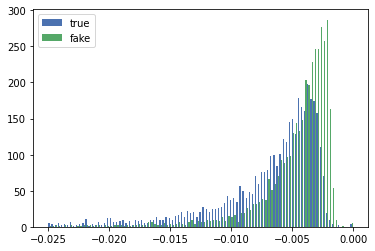

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

plt.style.use('seaborn-deep')

probabilites_true = [item[0] for item in probabilities if item[1] == 1]
probabilites_fake = [item[0] for item in probabilities if item[1] == 0]

# min_bound = math.floor(min(min(probabilites_true), min(probabilites_fake)))

x = probabilites_true
y = probabilites_fake
bins = np.linspace(-0.025, 0, 100)

plt.hist([x, y], bins, label=['true', 'fake'])
plt.legend(loc='upper left')
plt.show()

Best Threshold=0.504751, G-Mean=0.655


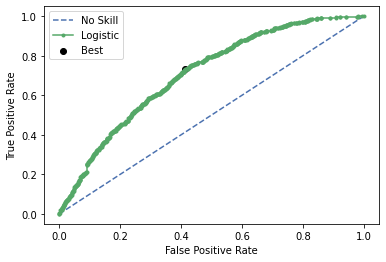

In [ ]:
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# roc curve for logistic regression model with optimal threshold
import numpy as np
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# generate dataset
X, y = [item[0] for item in probabilities], [item[1] for item in probabilities]

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
trainX = np.array(trainX).reshape(-1, 1)
testX = np.array(testX).reshape(-1, 1)

# fit a model
lg_model = LogisticRegression(solver='lbfgs')
lg_model.fit(trainX, trainy)

# predict probabilities
yhat = lg_model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
idx_best = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[idx_best], gmeans[idx_best]))
best_threshold = thresholds[idx_best]
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[idx_best], tpr[idx_best], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# predict probabilities
yhat = lg_model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

y_predictions = yhat >= thresholds[idx_best]
y_predictions = [y.astype(int) for y in y_predictions]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(testy, y_predictions)

array([[460, 323],
       [218, 592]])

In [ ]:
accuracy_score(testy, y_predictions)

0.6603892027620841

## Evaluating on Test Data

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats

split_bios = read_bios('/content/NLP-DL-Group2/hw#1/mix.test.txt', True)
windows = create_windows(split_bios, 3)

all_sliding_windows = [item[0] for item in windows]
all_bio_labels = [item[1] for item in windows]

BATCH_SIZE = 64

In [ ]:
# Now that we know the best threshold, we can apply that threshold to the test dataset

probabilities = []

for i in range(len(all_sliding_windows)):
  all_sliding_windows_for_bio = all_sliding_windows[i]
  context, true_words = make_context_and_true_words_per_bio(all_sliding_windows_for_bio)

  bio_label = all_bio_labels[i]

  # Each bio has a probability table (mapping words to their probabilities, given the sequence)
  log_probability_tables = model.lookup(context)

  normal_probabilities = torch.FloatTensor([])

  for idx_curr_context, probability_distributions_for_each_context in enumerate(log_probability_tables):
    true_word_for_curr_context = true_words[idx_curr_context]
    probability_for_true_word = probability_distributions_for_each_context[true_word_for_curr_context]
    probability_for_predicted_word = torch.max(probability_distributions_for_each_context)

    probability_normalized = (probability_for_predicted_word - probability_for_true_word) / (probability_for_predicted_word + 1e-9)

    normal_probabilities = torch.cat([normal_probabilities, probability_normalized])

  # Trimming mean by 0.05 (from each side) and dividing by the length
  trimmed_mean = stats.trim_mean(normal_probabilities.detach().numpy(), 0.05) / len(log_probability_tables)

  probabilities.append((trimmed_mean, bio_label))

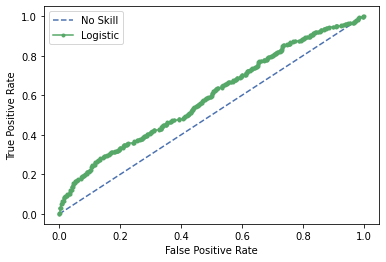

In [ ]:
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# roc curve for logistic regression model with optimal threshold
import numpy as np
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# generate dataset
X, y = [item[0] for item in probabilities], [item[1] for item in probabilities]
X = np.array(X).reshape(-1, 1)

# split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
# trainX = np.array(trainX).reshape(-1, 1)
# testX = np.array(testX).reshape(-1, 1)

# fit a model
# lg_model = LogisticRegression(solver='lbfgs')
# lg_model.fit(trainX, trainy)

# predict probabilities
yhat = lg_model.predict_proba(X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, _ = roc_curve(y, yhat)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# predict probabilities
yhat = lg_model.predict_proba(X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

y_predictions = yhat >= best_threshold
y_predictions = [y.astype(int) for y in y_predictions]

In [ ]:
confusion_matrix(y, y_predictions)

array([[303, 244],
       [231, 274]])

In [ ]:
accuracy_score(y, y_predictions)

0.5484790874524715